 # Лабораторная работа №3

Выполнила Рындина Валерия, M33351

## Меня ждут миллионы

Обучите простую модель предсказания цены акций. Используйте один из рассмотренных на лекции "Временные последовательности" алгоритмов предсказания рядов. Можно использовать и более сложные алгоритмы предсказания рядов


1. Найдите данные о цене любого биржевого актива

    Данные должны содержать значение цены актива как минимум за каждый день и длительностю как минимум за год. 

    Найти данные можно на kaggle или использовать FAANG датасет из 1 лабораторной

In [17]:
%pip install numpy==1.19.5
%pip install pandas==1.2.3
import pandas as pd
import statsmodels
from matplotlib import pyplot as plt
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from itertools import product
import statsmodels.api as sm
from tqdm import tqdm

Note: you may need to restart the kernel to use updated packages.
  Using cached pandas-1.2.3-cp38-cp38-manylinux1_x86_64.whl (9.7 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 0.25.3
    Uninstalling pandas-0.25.3:
      Successfully uninstalled pandas-0.25.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
packageforlab2 0.1 requires pandas<1.0, but you have pandas 1.2.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [18]:
dt_init= pd.read_csv('data/raw/Netflix_Historical_StockPrice2.csv')

2. Предобработайте данные

    Временной ряд сложно предсказывать по дням. Сделайте ряд по неделям или месяцам

In [19]:
dt_init.Date = pd.to_datetime(dt_init.Date, errors='coerce')
dt_init.High = pd.to_numeric(dt_init.High, errors='coerce')

dt_init.Date = dt_init['Date'].dt.strftime('%Y-%m')

df = pd.DataFrame(dt_init.groupby('Date').High.mean())
df.High = pd.to_numeric(df.High, errors='coerce')

<AxesSubplot:title={'center':'Time series'}, xlabel='Date', ylabel='Price'>

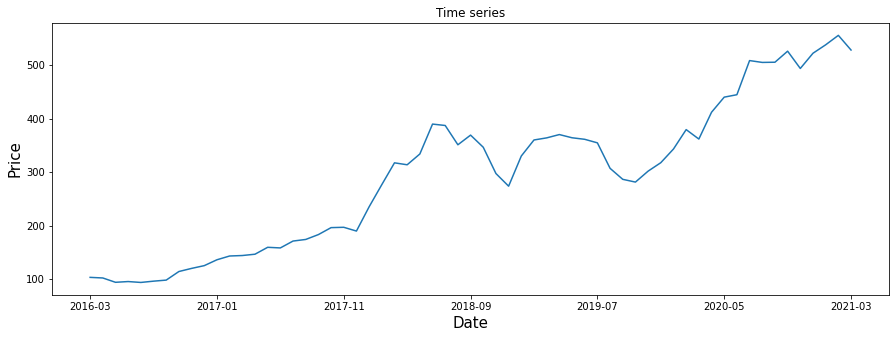

<AxesSubplot:title={'center':'Time series'}, xlabel='Date', ylabel='Price'>

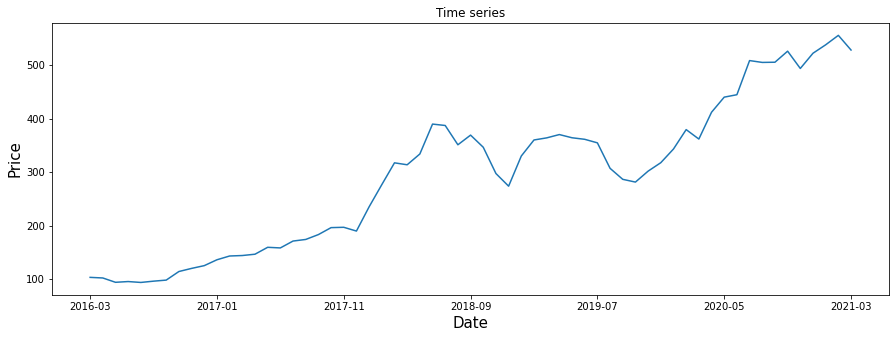

In [20]:
plt.figure(figsize=(15, 5))
plt.title('Time series')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', rotation=90, fontsize=15)
df.High.plot()

Удалите из ряда тренд, если он есть. Используйте другие рассмотренные на лекции приёмы

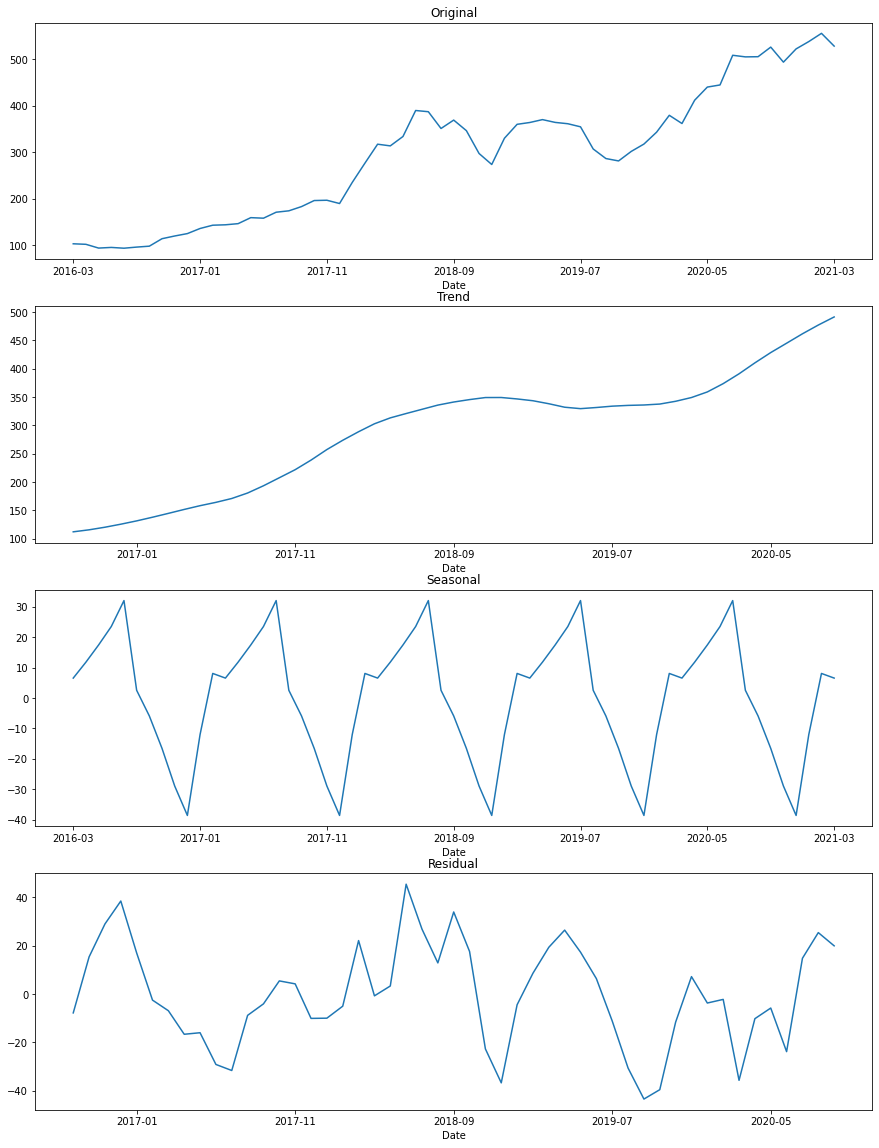

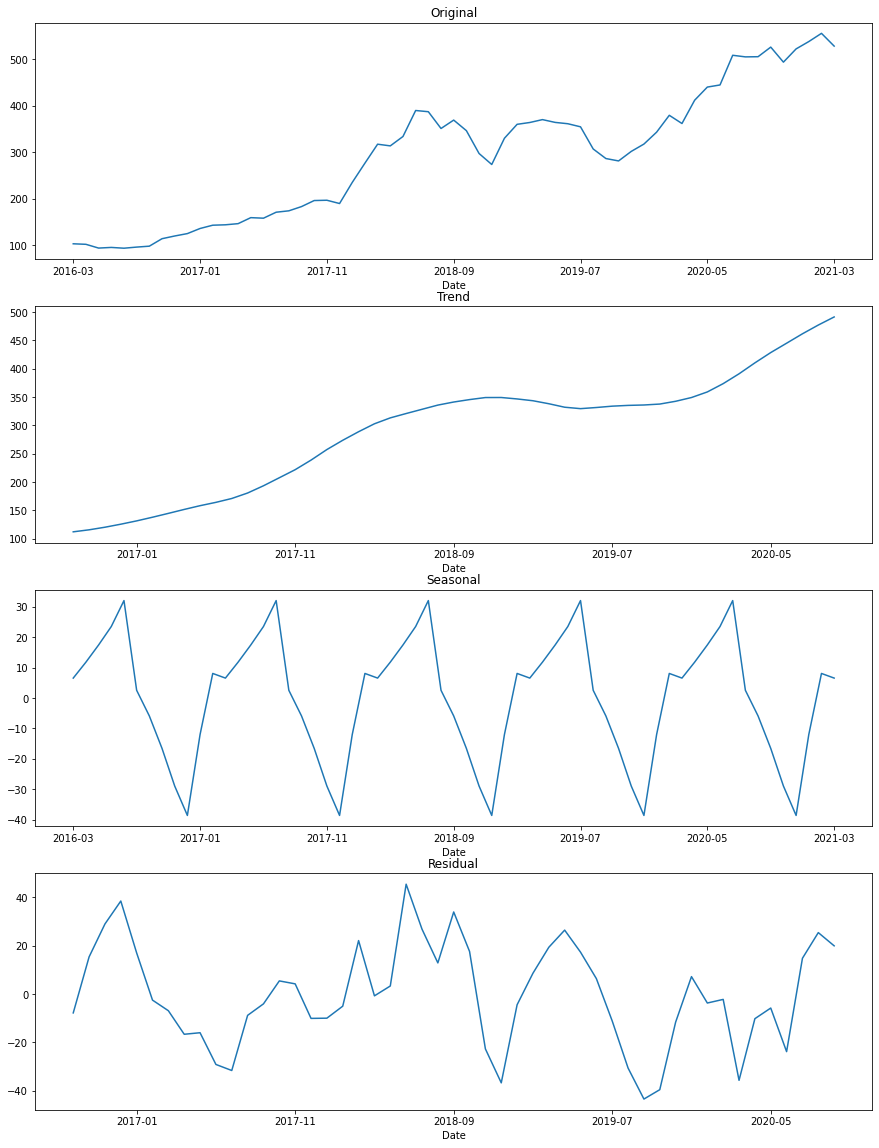

In [21]:
SHIFT = 12

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 20))
decompose = seasonal_decompose(df[['High']], period=SHIFT)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

Избавимся от тренда. Для этого логорифмируем все данные и построим график

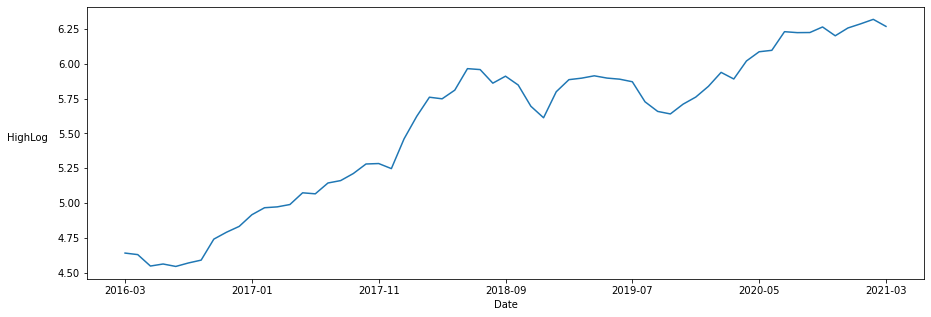

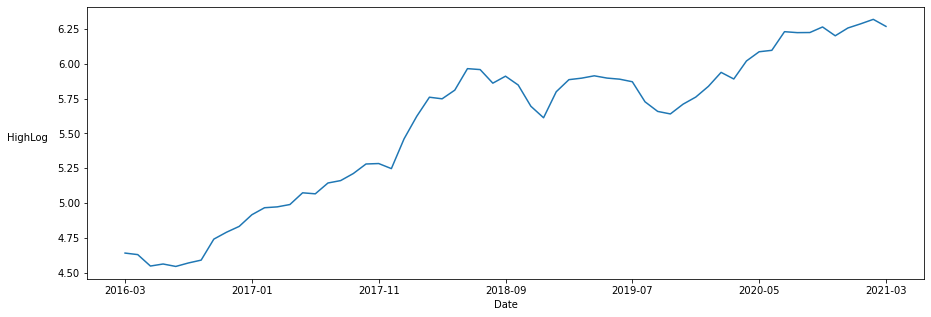

In [22]:
df['HighLog'] = np.log(df['High'])

plt.figure(figsize=(15, 5))
plt.ylabel('HighLog', rotation=0, labelpad=30)
df['HighLog'].plot();

Полученный уровень значимости (p-value): 0.3788. 0.3788 > 0.05. Нулевая гипотеза не отвергается в пользу альтернативной!


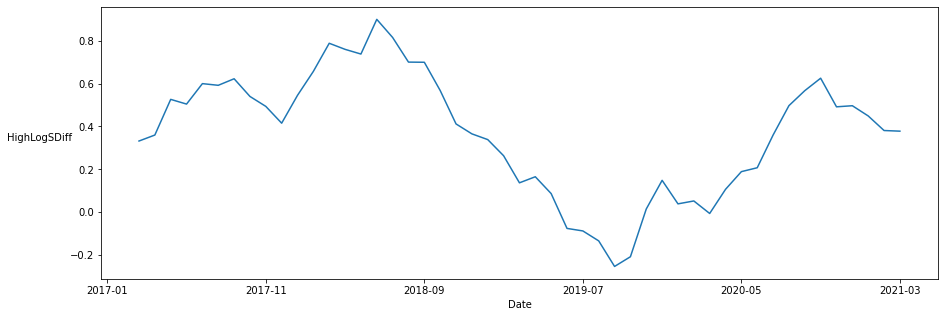

Полученный уровень значимости (p-value): 0.3788. 0.3788 > 0.05. Нулевая гипотеза не отвергается в пользу альтернативной!


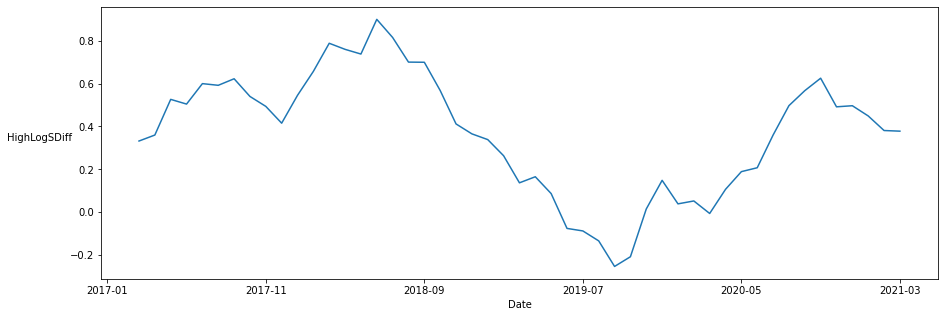

In [23]:
df['HighLogSDiff'] = df['HighLog'] - df['HighLog'].shift(SHIFT)
p_value = adfuller(df["HighLogSDiff"][SHIFT:])[1]

print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} > 0.05. Нулевая гипотеза не отвергается в пользу альтернативной!'
)

plt.figure(figsize=(15, 5))
plt.ylabel('HighLogSDiff', rotation=0, labelpad=30)
df['HighLogSDiff'].plot();

/home/valrun/Repositories/CT-19/5 sem/pythonProject/venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


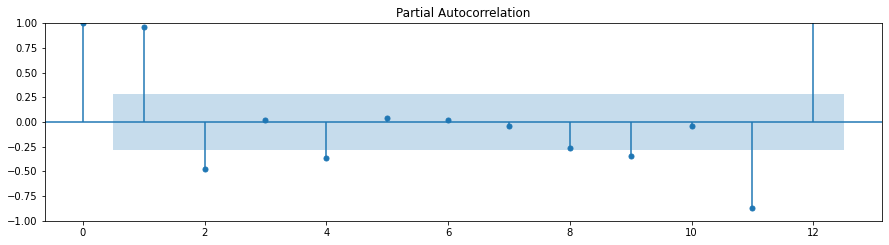

In [34]:
plt.figure(figsize=(15,8))
ax = plt.subplot(212)
statsmodels.graphics.tsaplots.plot_pacf(df['HighLogSDiff'][SHIFT:], lags=12, ax=ax);

3. Обучите модель

    Обучите модель на 80% временного ряда

    Предскажите оставшиеся 20% (как минимум 3 точки) ряда с помощью модели

    Отобразите на графике предсказание модели и истинные данные


In [25]:
d=1
D=range(0,2)

qs = range(1, 4)
Qs = range(1, 3)

ps = range(1, 4)
Ps = range(1, 4)

size = len(df.HighLog)
train_size = int(0.8 * size)

X_train = df['HighLog'][:train_size]
X_test = df['HighLog'][train_size:]
y_train = df['High'][:train_size]
y_test = df['High'][train_size:]

X_train.tail()

Date
2019-10    5.640095
2019-11    5.710208
2019-12    5.761164
2020-01    5.838476
2020-02    5.938807
Name: HighLog, dtype: float64

Date
2019-10    5.640095
2019-11    5.710208
2019-12    5.761164
2020-01    5.838476
2020-02    5.938807
Name: HighLog, dtype: float64

In [26]:
parameters = product(ps, qs, Ps, D, Qs)
parameters_list = list(parameters)
len(parameters_list)

108

108

Пытаемся тренировать алгоритм SARIMAX

In [27]:
%%time

results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model = sm.tsa.statespace.SARIMAX(
            X_train,
            order=(param[0], d, param[1]),
            seasonal_order=(param[2], param[3], param[4], 6)
        ).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

  0%|          | 0/108 [00:00<?, ?it/s]/home/valrun/Repositories/CT-19/5 sem/pythonProject/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/valrun/Repositories/CT-19/5 sem/pythonProject/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
  1%|          | 1/108 [00:02<04:11,  2.35s/it]/home/valrun/Repositories/CT-19/5 sem/pythonProject/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/valrun/Repositories/CT-19/5 sem/pythonProject/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: V

CPU times: user 11min 16s, sys: 11min 3s, total: 22min 20s
Wall time: 2min 4s



  0%|          | 0/108 [00:00<?, ?it/s]/home/valrun/Repositories/CT-19/5 sem/pythonProject/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/valrun/Repositories/CT-19/5 sem/pythonProject/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
  1%|          | 1/108 [00:00<00:41,  2.57it/s]/home/valrun/Repositories/CT-19/5 sem/pythonProject/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/valrun/Repositories/CT-19/5 sem/pythonProject/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: 

CPU times: user 11min 9s, sys: 10min 54s, total: 22min 4s
Wall time: 1min 56s


Получаем результаты и выбираем из них лучший

In [28]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

print(best_model.summary())

         parameters         aic
0   (1, 1, 1, 0, 1) -101.110254
1   (1, 1, 1, 0, 2) -100.731564
4   (1, 1, 2, 0, 1) -100.564335
12  (1, 2, 1, 0, 1) -100.002032
13  (1, 2, 1, 0, 2)  -99.695745
                                     SARIMAX Results                                     
Dep. Variable:                           HighLog   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 6)   Log Likelihood                  55.555
Date:                           Wed, 22 Dec 2021   AIC                           -101.110
Time:                                   18:36:02   BIC                            -91.860
Sample:                               03-01-2016   HQIC                           -97.629
                                    - 02-01-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------

Строим график отклонений и автокорреляции по лучшей модели

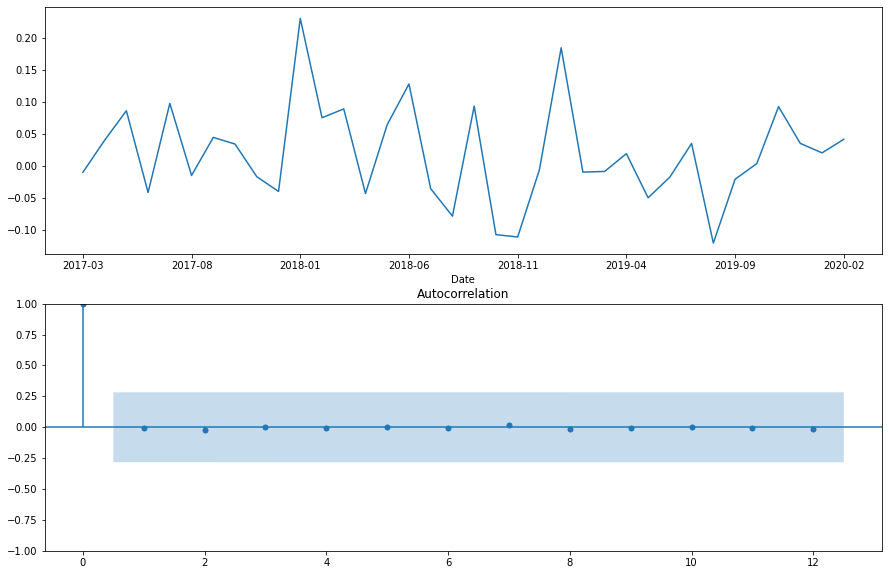

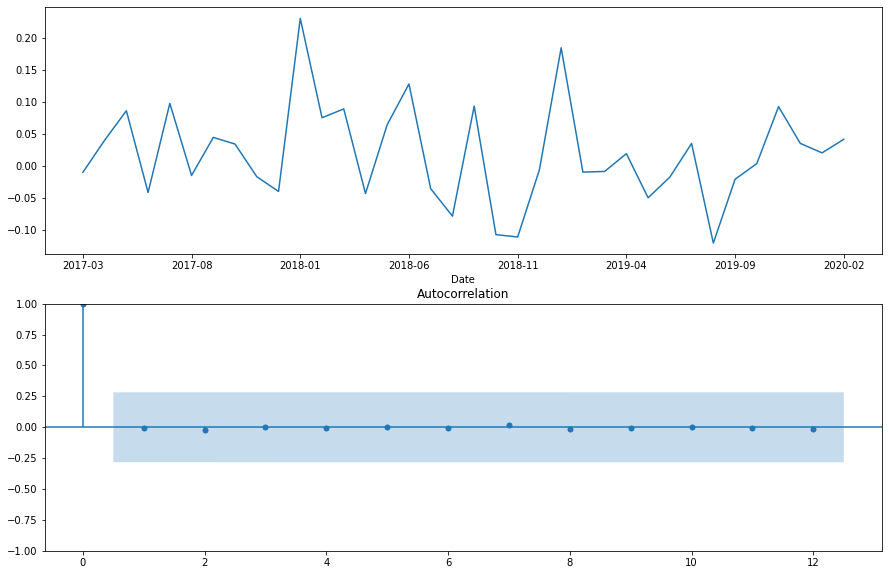

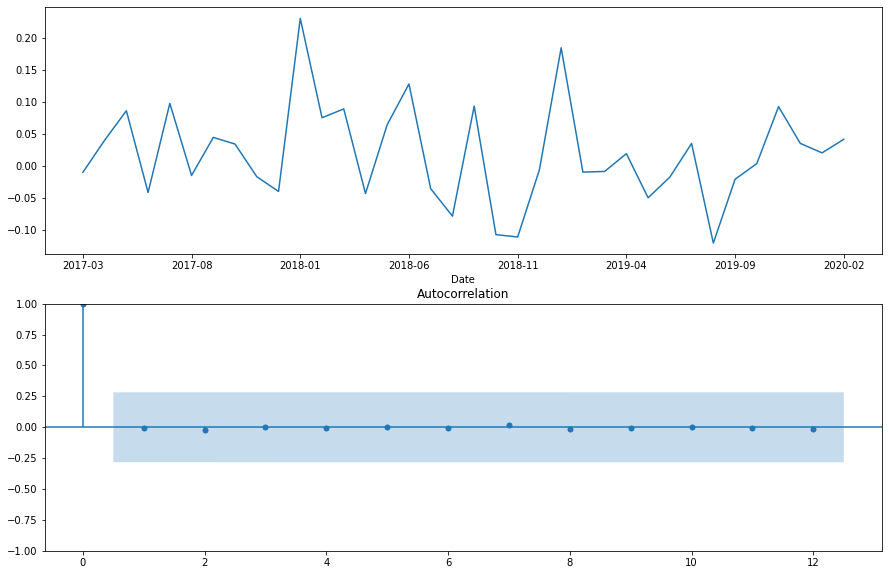

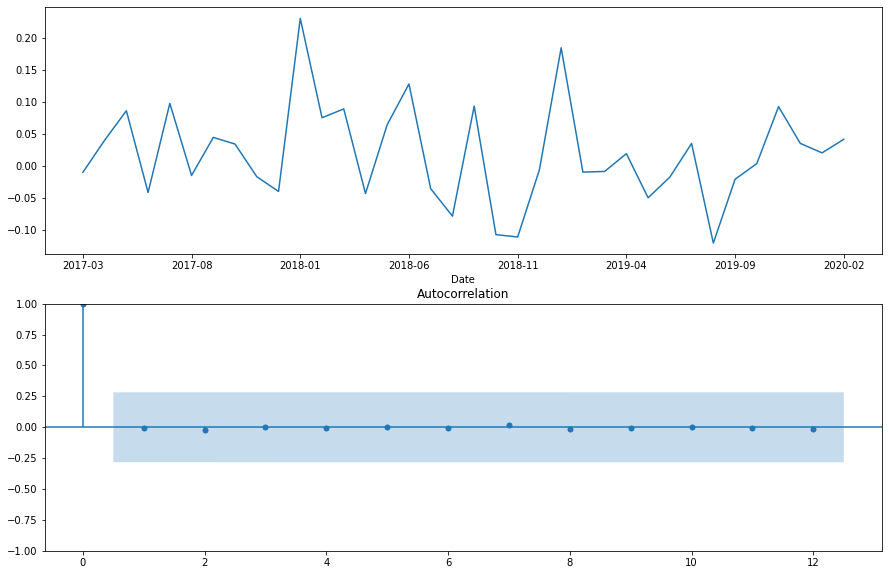

In [29]:
plt.figure(figsize=(15,10))

plt.subplot(211)
best_model.resid[SHIFT:].plot()

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=12, ax=ax)

Тестируем

/tmp/ipykernel_13570/2005522890.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Model'] = predicted


<AxesSubplot:xlabel='Date'>

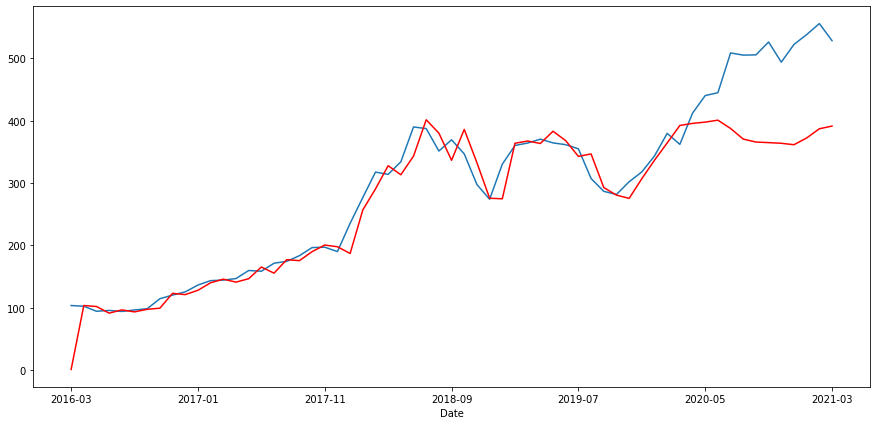

/tmp/ipykernel_13570/2005522890.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Model'] = predicted


<AxesSubplot:xlabel='Date'>

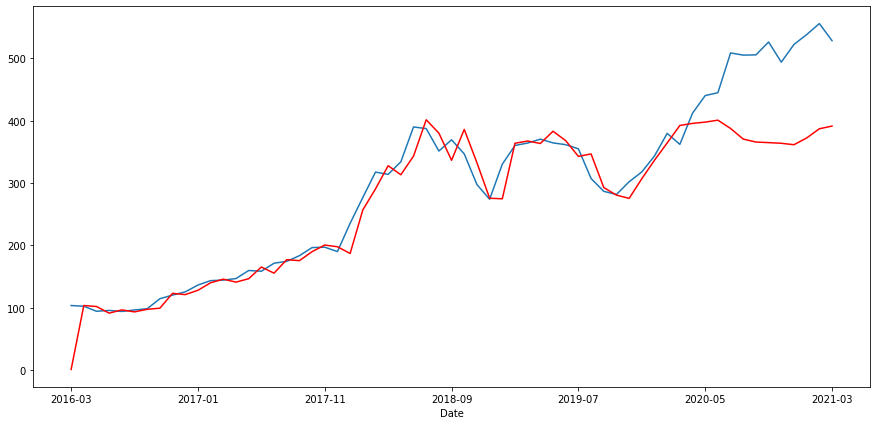

In [30]:
predicted = [
    np.exp(best_model.predict(i)).values[0]
    for i in range(0, size)
]

new_df = df[['High']]
new_df['Model'] = predicted

plt.figure(figsize=(15,7))
new_df['High'].plot()
new_df['Model'].plot(c='r')

4. Посчитайте метрику

    Метрика должна отражать разницу между предсказанными и истинными данными. Можно выбрать меру MAPE, можно предложить свою

In [31]:
predicted_df = new_df.iloc[train_size : size][['High', 'Model']]
actual = predicted_df['High'].to_numpy()
predicted = predicted_df['Model'].to_numpy()

In [32]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(actual, predicted)
print(mape)

0.2191668360772202
0.2191668360772202
